In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
%matplotlib inline

# 1. Data Preparation and Cleaning

you can see information about the dataset from this link https://archive.ics.uci.edu/ml/datasets/Bank+Marketing <br>
after downloading the bank.zip file and unzip it, you can see two files one for training & evaluating and one for testing

In [2]:
df = pd.read_csv('bank-full.csv',sep=';')
print("\nNumber of samples:",df.shape[0],"and number of features:",df.shape[1],"\n")
# read the data and display the first 5 rows
df.head()


Number of samples: 45211 and number of features: 17 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


 ##### Information about our dataset:
   1. age (numeric)
   2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",      "blue-collar","self-employed","retired","technician","services")
   3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4. education (categorical: "unknown","secondary","primary","tertiary")
   5. default: has credit in default? (binary: "yes","no")
   6. balance: average yearly balance, in euros (numeric) 
   7. housing: has housing loan? (binary: "yes","no")
   8. loan: has personal loan? (binary: "yes","no")
      related with the last contact of the current campaign:
   9. contact: contact communication type (categorical: "unknown","telephone","cellular")
   10. day: last contact day of the month (numeric)
   11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   12. duration: last contact duration, in seconds (numeric)<br>
**other attributes:**
   13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
   15. previous: number of contacts performed before this campaign and for this client (numeric)
   16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  **Output variable (desired target):**<br>
   17. y - has the client subscribed a term deposit? (binary: "yes","no")

In [3]:
df.y = (df.y == 'yes').astype(int) #changing our output (y) from categorical to numerical

In [4]:
df['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [5]:
df['job'].replace({'admin.': 'admin'}, inplace=True)#cleaning_data

In [6]:
df['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin            5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

**Data is clean and ready to the next step Exploratory Data Analysis (EDA)**

# 2.Exploratory Data Analysis (EDA)

1. Explore our data more.
2. Turning balance from long tail into normal distribution.
3. Check for missing values.
4. Looking at the target "y" distribution.
5. Feauture important analysis.

### 2.1 Explore our data more.

In [7]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [8]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

age
[58 44 33 47 35]
77

job
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown']
12

marital
['married' 'single' 'divorced']
3

education
['tertiary' 'secondary' 'unknown' 'primary']
4

default
['no' 'yes']
2

balance
[2143   29    2 1506    1]
7168

housing
['yes' 'no']
2

loan
['no' 'yes']
2

contact
['unknown' 'cellular' 'telephone']
3

day
[5 6 7 8 9]
31

month
['may' 'jun' 'jul' 'aug' 'oct']
12

duration
[261 151  76  92 198]
1573

campaign
[1 2 3 5 4]
48

pdays
[ -1 151 166  91  86]
559

previous
[0 3 1 4 2]
41

poutcome
['unknown' 'failure' 'other' 'success']
4

y
[0 1]
2



### 2.2 Turning balance from long tail into normal distribution.

**The balance distribution isn't so good and it has a tail.**<br>
**So we need to make it in normal distribution shape -because it's more relative numbers to the dataset- by using np.log1p().**

<AxesSubplot:xlabel='balance', ylabel='Count'>

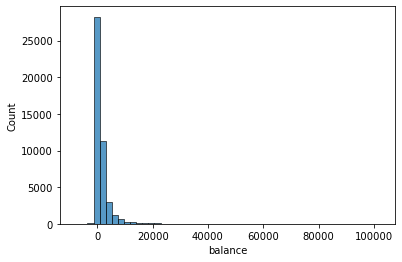

In [9]:
sns.histplot(df.balance, bins=50)

In [10]:
#df["balance"].replace({-1: 0}, inplace=True) 
#since this is balance in € yearly so it doesn't make a difference to add one € to (-1€) values,
#to avoid error dividing by 0 in np.log1p()
df['balance'] = df['balance'].mask(df['balance'] < 0, 0)

<AxesSubplot:xlabel='balance', ylabel='Count'>

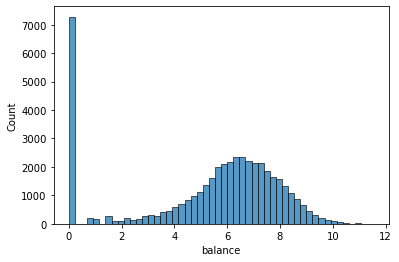

In [11]:
balance_logs = np.log1p(df.balance)
sns.histplot(balance_logs, bins=50)

In [12]:
df['balance_logs'] = balance_logs
df=df.copy()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,balance_logs
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,7.670429
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,3.401197
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,1.098612
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,7.317876
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,0.693147


In [13]:
del df['balance']# we delete balance and replacing it with balance_logs because it will do better in the model.
df=df[['age', 'job', 'marital', 'education', 'default', 'balance_logs', 'housing', 'loan',
       'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'y']]# reordering DataFrame
df.head()

,age,job,marital,education,default,balance_logs,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,7.670429,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,3.401197,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,1.098612,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,7.317876,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,0.693147,no,no,unknown,5,may,198,1,-1,0,unknown,0


### 2.3 Check for missing values.

In [14]:
df.isnull().sum()

age             0
job             0
marital         0
education       0
default         0
balance_logs    0
housing         0
loan            0
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
y               0
dtype: int64

In [15]:
df.balance_logs = df.balance_logs.fillna(0)
df.isnull().sum()

age             0
job             0
marital         0
education       0
default         0
balance_logs    0
housing         0
loan            0
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
y               0
dtype: int64

### 2.4 Looking at the target "y" distribution.

In [16]:
df.y.value_counts(normalize=True)

0    0.883015
1    0.116985
Name: y, dtype: float64

**In this case we will use F1-score and AUC to validate our model instead of accuracy.**

### 2.5 Feautures importance analysis (mutual information & correlation)

In [17]:
df.dtypes

age               int64
job              object
marital          object
education        object
default          object
balance_logs    float64
housing          object
loan             object
contact          object
day               int64
month            object
duration          int64
campaign          int64
pdays             int64
previous          int64
poutcome         object
y                 int32
dtype: object

In [18]:
numerical = ['age', 'balance_logs', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical  = ['job', 'marital', 'education', 'default',  'housing', 'loan',
       'contact', 'month', 'poutcome']

In [19]:
from sklearn.metrics import mutual_info_score
def mutual_info_churn_score(series):
    return mutual_info_score(series, df.y)
mi = df[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

poutcome     0.029397
month        0.024351
contact      0.013627
housing      0.009654
job          0.008264
loan         0.002630
education    0.002598
marital      0.002101
default      0.000294
dtype: float64

In [20]:
corr=df[numerical].corrwith(df.y)
corr.sort_values(ascending=False)

duration        0.394521
pdays           0.103621
balance_logs    0.094435
previous        0.093236
age             0.025155
day            -0.028348
campaign       -0.073172
dtype: float64

In [21]:
df[df.duration >= 700].y.mean()# it shows that people who haven't yet contacted them for over than 700 days,
                                #they have good chance of accepting our offer. 

0.5305970149253731

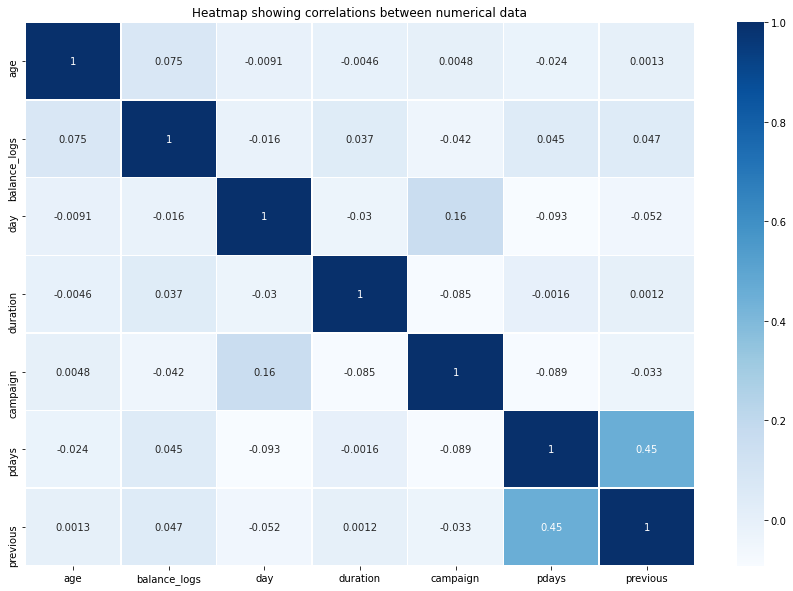

In [22]:
plt.figure(figsize=(15,10))  
sns.heatmap(df[numerical].corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

# 3. Training & Tuning Different Models

1. [Splitting the data.](#3.1-Splitting-the-data.)
2. [One-hot encoding.](#3.2-One-hot-encoding.)
3. [Evaluation Metrics.](#3.3-Evaluation-Metrics)
4. [LogisticRegression model.](#3.4-LogisticRegression-model.)
5. [DecisionTreeClassifier model.](#3.5-DecisionTreeClassifier-model.)
    1. [Best DecisionTreeClassifier model.](#3.6.A.The-Best-Random-Forest-Model)
6. [RandomForestClassifier model.](#3.6-RandomForestClassifier-model.)
    1. [Best RandomForestClassifier model](#3.6.A.The-Best-Random-Forest-Model)
7. [XGBoost model.](#3.7-XGBoost-model.)
    1. [Best XGBoost model.](#XGB-model-with-the-best-parameters-we-got-from-the-(GridSearchCV).**)

In [23]:
features = ['age', 'job', 'marital', 'education', 'default', 'balance_logs', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome']

### 3.1 Splitting the data.

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=1)

print("samples in the new training subset:",len(df_train))
print("samples in the new test subset:",len(df_val))

samples in the new training subset: 36168
samples in the new test subset: 9043


In [26]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values

### 3.2 One-hot encoding.

In [27]:
from sklearn.feature_extraction import DictVectorizer
train_dict = df_train[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [28]:
test_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(test_dict)

### 3.3 Evaluation Metrics

After each model we will use **confusion matrix**, **F1_score**, **AUC** on validation and training dataframes.<br>
The reason for applying AUC on training dataset to see if the model overfitted or not.

In [29]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

### 3.4 LogisticRegression model.

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
model1 = LogisticRegression(solver='lbfgs',max_iter=10000)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model1.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [32]:
y_pred = model1.predict_proba(X_val)[:, 1]
subscription_decision = (y_pred >= 0.2)
accuracy = (y_val == subscription_decision).mean()
roc = roc_auc_score(y_val, y_pred)
f1=f1_score(y_val, subscription_decision, average='binary')
print ('The accuracy = %.4f, auc = %.4f, f1_score = %.4f' %(accuracy, roc, f1))

The accuracy = 0.8860, auc = 0.9084, f1_score = 0.5841


### 3.5 DecisionTreeClassifier model.

In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
depths = [1, 2, 3, 4, 5, 6, 8, 9, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred1 = dt.predict_proba(X_val)[:, 1]
    subscription_decision = (y_pred1 >= 0.5)
    auc_val = roc_auc_score(y_val, y_pred1)
    f1=f1_score(y_val, subscription_decision, average='binary')
    
    
    y_pred2 = dt.predict_proba(X_train)[:, 1]
    auc_train = roc_auc_score(y_train, y_pred2)
    
    print('%4s -> %.3f \t %.3f \t %.3f' % (depth, auc_val, f1, auc_train))

   1 -> 0.671 	 0.000 	 0.687
   2 -> 0.755 	 0.444 	 0.760
   3 -> 0.774 	 0.462 	 0.783
   4 -> 0.791 	 0.431 	 0.799
   5 -> 0.801 	 0.460 	 0.815
   6 -> 0.845 	 0.482 	 0.865
   8 -> 0.852 	 0.500 	 0.895
   9 -> 0.851 	 0.495 	 0.911
  10 -> 0.848 	 0.530 	 0.925
  15 -> 0.732 	 0.513 	 0.970
  20 -> 0.677 	 0.514 	 0.994
None -> 0.723 	 0.502 	 1.000


In [35]:
scores = []

for depth in [5, 6, 8, 10, None]:
    for s in [1, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred1 = dt.predict_proba(X_val)[:, 1]
        subscription_decision = (y_pred1 >= 0.5)
        auc_val = roc_auc_score(y_val, y_pred1)
        f1=f1_score(y_val, subscription_decision, average='binary')


        y_pred2 = dt.predict_proba(X_train)[:, 1]
        auc_train = roc_auc_score(y_train, y_pred2)

        print('%4s -> %.0f \t %.3f \t %.3f \t %.3f' % (depth, s, auc_val, f1, auc_train))
        scores.append((depth, s, auc_val, f1, auc_train))

   5 -> 1 	 0.801 	 0.460 	 0.815
   5 -> 5 	 0.801 	 0.460 	 0.814
   5 -> 10 	 0.801 	 0.455 	 0.814
   5 -> 15 	 0.801 	 0.455 	 0.814
   5 -> 20 	 0.801 	 0.461 	 0.814
   5 -> 100 	 0.801 	 0.467 	 0.814
   5 -> 200 	 0.799 	 0.436 	 0.812
   5 -> 500 	 0.851 	 0.485 	 0.859
   6 -> 1 	 0.845 	 0.482 	 0.865
   6 -> 5 	 0.845 	 0.477 	 0.865
   6 -> 10 	 0.846 	 0.483 	 0.865
   6 -> 15 	 0.846 	 0.484 	 0.865
   6 -> 20 	 0.847 	 0.478 	 0.865
   6 -> 100 	 0.848 	 0.476 	 0.863
   6 -> 200 	 0.846 	 0.477 	 0.860
   6 -> 500 	 0.870 	 0.485 	 0.876
   8 -> 1 	 0.854 	 0.503 	 0.895
   8 -> 5 	 0.863 	 0.502 	 0.894
   8 -> 10 	 0.861 	 0.514 	 0.893
   8 -> 15 	 0.864 	 0.508 	 0.892
   8 -> 20 	 0.867 	 0.508 	 0.891
   8 -> 100 	 0.878 	 0.499 	 0.890
   8 -> 200 	 0.879 	 0.477 	 0.888
   8 -> 500 	 0.887 	 0.485 	 0.891
  10 -> 1 	 0.845 	 0.525 	 0.925
  10 -> 5 	 0.868 	 0.535 	 0.923
  10 -> 10 	 0.877 	 0.535 	 0.919
  10 -> 15 	 0.882 	 0.524 	 0.918
  10 -> 20 	 0.891 

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

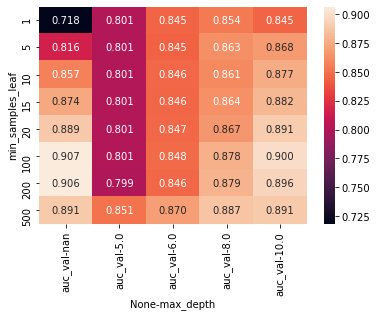

In [36]:
columns = ['max_depth', 'min_samples_leaf', 'auc_val', 'f1', 'auc_train']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc_val'])
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

from the heatmap we can see that our best auc_val is when (max_depth=None, mix_samples_leaf=100)

### 3.5.A.The Best Decision Tree Model

In [37]:
model2 = DecisionTreeClassifier(max_depth=None, min_samples_leaf=100)
model2.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=100)

In [38]:
y_pred1 = model2.predict_proba(X_val)[:, 1]
subscription_decision = (y_pred1 >= 0.30)
auc_val = roc_auc_score(y_val, y_pred1)
f1=f1_score(y_val, subscription_decision, average='binary')

y_pred2 = model2.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred2)

print('auc_val= %.3f \t f1= %.3f\t auc_train= %.3f' % (auc_val, f1, auc_train))


auc_val= 0.907 	 f1= 0.577	 auc_train= 0.928


In [39]:
#just to know our model features
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- duration <= 473.50
|   |--- poutcome=success <= 0.50
|   |   |--- age <= 60.50
|   |   |   |--- duration <= 206.50
|   |   |   |   |--- duration <= 111.50
|   |   |   |   |   |--- duration <= 78.50
|   |   |   |   |   |   |--- education=tertiary <= 0.50
|   |   |   |   |   |   |   |--- marital=single <= 0.50
|   |   |   |   |   |   |   |   |--- month=jul <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- month=jul >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- marital=single >  0.50
|   |   |   |   |   |   |   |   |--- balance_logs <= 5.82
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- balance_logs >  5.82
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- education=tertiary >  0.50
|   |   |   |   |   |   |   |--- duration <= 60.50
|   |   |   |   |   |   |   |   |--- duration <= 36.50
|   |   |   |   |   |   |   |   |   |--- 

**Getting the best threshold for f1_score & seeing the presicion and recall value**

In [40]:
df_scores = confusion_matrix_dataframe(y_val, y_pred1)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1050,7993,0,0
10,0.1,944,1752,106,6241
20,0.2,830,1058,220,6935
30,0.3,716,716,334,7277
40,0.4,582,459,468,7534
50,0.5,426,274,624,7719
60,0.6,288,130,762,7863
70,0.7,178,64,872,7929
80,0.8,50,12,1000,7981
90,0.9,0,0,1050,7993


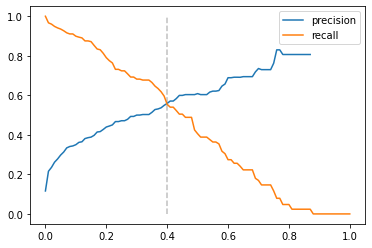

In [41]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.4, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

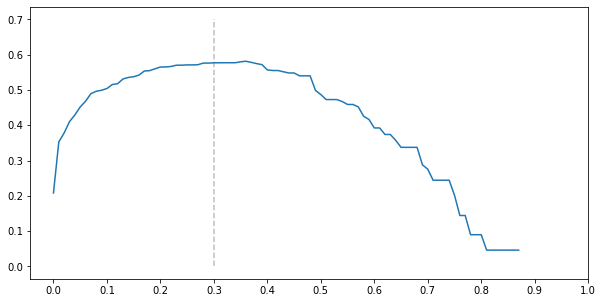

In [42]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

plt.figure(figsize=(10, 5))
plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.3, 0, 0.7, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

so the best F1_score threshold = 0.3 and that is our best decision tree model.

### 3.6 RandomForestClassifier model.

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
scores = []

for n in range(10, 251, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]  
    subscription_decision = (y_pred >= 0.3)
    auc_val = roc_auc_score(y_val, y_pred)
    f1=f1_score(y_val, subscription_decision, average='binary')
    
    y_pred2 = rf.predict_proba(X_train)[:, 1]
    auc_train = roc_auc_score(y_train, y_pred2)
    print('%4s -> auc_val= %.3f\t f1= %.3f\t auc_train=%.3f' % (n, auc_val, f1, auc_train))

    scores.append((n, auc_val, f1, auc_train))

  10 -> auc_val= 0.894	 f1= 0.574	 auc_train=1.000
  20 -> auc_val= 0.916	 f1= 0.600	 auc_train=1.000
  30 -> auc_val= 0.921	 f1= 0.602	 auc_train=1.000
  40 -> auc_val= 0.923	 f1= 0.606	 auc_train=1.000
  50 -> auc_val= 0.925	 f1= 0.611	 auc_train=1.000
  60 -> auc_val= 0.927	 f1= 0.615	 auc_train=1.000
  70 -> auc_val= 0.927	 f1= 0.611	 auc_train=1.000
  80 -> auc_val= 0.927	 f1= 0.612	 auc_train=1.000
  90 -> auc_val= 0.928	 f1= 0.609	 auc_train=1.000
 100 -> auc_val= 0.929	 f1= 0.611	 auc_train=1.000
 110 -> auc_val= 0.929	 f1= 0.615	 auc_train=1.000
 120 -> auc_val= 0.929	 f1= 0.612	 auc_train=1.000
 130 -> auc_val= 0.929	 f1= 0.609	 auc_train=1.000
 140 -> auc_val= 0.930	 f1= 0.611	 auc_train=1.000
 150 -> auc_val= 0.930	 f1= 0.611	 auc_train=1.000
 160 -> auc_val= 0.930	 f1= 0.616	 auc_train=1.000
 170 -> auc_val= 0.930	 f1= 0.617	 auc_train=1.000
 180 -> auc_val= 0.930	 f1= 0.615	 auc_train=1.000
 190 -> auc_val= 0.930	 f1= 0.615	 auc_train=1.000
 200 -> auc_val= 0.930	 f1= 0.6

As we can see auc_train =1 because the max depth is set to None, so we need to tune it.

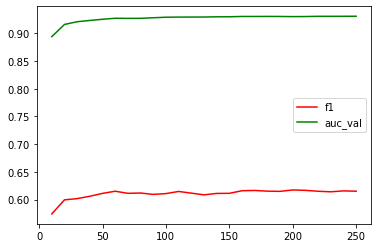

In [45]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc_val', 'f1','auc_train'])
plt.plot(df_scores.n_estimators, df_scores.f1, label='f1', color='red')
plt.plot(df_scores.n_estimators, df_scores.auc_val, label='auc_val',color='green')

plt.legend()
plt.show()

In [46]:
scores = []

for d in [5, 10, 15, 17]:
    for n in range(10, 111, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        subscription_decision = (y_pred >= 0.3)
        auc_val = roc_auc_score(y_val, y_pred)
        f1=f1_score(y_val, subscription_decision, average='binary')
        
        y_pred = rf.predict_proba(X_train)[:, 1]
        auc_train = roc_auc_score(y_train, y_pred)
        #print('d= %4s -> n= %.0f\t auc_val= %.3f\t f1= %.3f\t auc_train=%.3f' % (d, n, auc_val, f1, auc_train))
        #print statment is for reading but visualizing is better
        
        scores.append((d, n, auc_val, auc_train, f1))

d= 15 -> n=60 ,auc_val= 0.929	 f1= 0.616	 auc_train=0.984

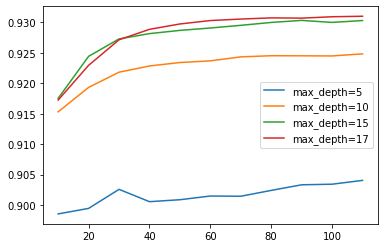

In [47]:
columns = ['max_depth', 'n_estimators', 'auc_val','auc_train','f1']
df_scores = pd.DataFrame(scores, columns=columns)

for d in [5, 10, 15, 17]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators,  df_subset.auc_val,
             label='max_depth=%d' % d)

plt.legend()

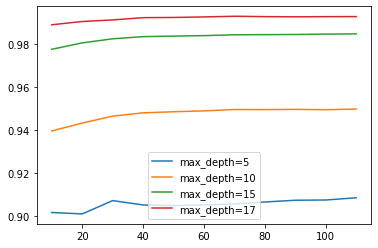

In [48]:
for d in [5, 10, 15, 17]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators,  df_subset.auc_train,
             label='max_depth=%d' % d)

plt.legend()

In [49]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 251, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=15,
                                    min_samples_leaf=s,
                                    random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        subscription_decision = (y_pred >= 0.3)
        auc_val = roc_auc_score(y_val, y_pred)
        f1=f1_score(y_val, subscription_decision, average='binary')
        
        y_pred = rf.predict_proba(X_train)[:, 1]
        auc_train = roc_auc_score(y_train, y_pred)
        
       
        #print('s= %1s -> n= %.0f\t auc_val= %.3f\t f1= %.3f\t auc_train=%.3f' % (s, n, auc_val, f1, auc_train))
        #print statment is for reading but visualizing is better
        scores.append((s, n, auc_val, auc_train, f1))

s=   10 -> n= 250	 auc_val= 0.930	 f1= 0.611	 auc_train=0.957

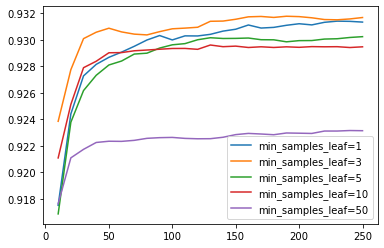

In [50]:
columns = ['min_samples_leaf', 'n_estimators', 'auc_val','auc_train','f']
df_scores = pd.DataFrame(scores, columns=columns)

for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators,  df_subset.auc_val,
             label='min_samples_leaf=%d' % s)

plt.legend()

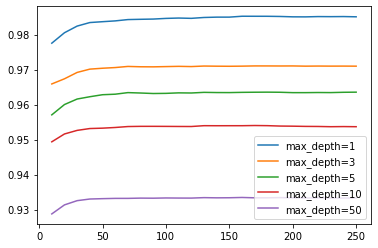

In [51]:
for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators,  df_subset.auc_train,
             label='max_depth=%d' % s)

plt.legend()

In [52]:
rf = RandomForestClassifier(n_estimators=250,
                            max_depth=15,
                            min_samples_leaf=3,
                            random_state=1, bootstrap=True, max_features= 16, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=16, min_samples_leaf=3,
                       n_estimators=250, n_jobs=-1, random_state=1)

In [53]:
y_pred = rf.predict_proba(X_val)[:, 1]
subscription_decision = (y_pred >= 0.3)
auc_val = roc_auc_score(y_val, y_pred)
f1=f1_score(y_val, subscription_decision, average='binary')

y_pred = rf.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred)


print('auc_val= %.3f\t f1= %.3f\t auc_train=%.3f' %(auc_val, f1, auc_train))

auc_val= 0.932	 f1= 0.615	 auc_train=0.978


In [54]:
rf = RandomForestClassifier(n_estimators=250,
                            max_depth=15,
                            min_samples_leaf=3,
                            random_state=1, bootstrap=False, max_features= 16, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=15, max_features=16,
                       min_samples_leaf=3, n_estimators=250, n_jobs=-1,
                       random_state=1)

In [55]:
y_pred = rf.predict_proba(X_val)[:, 1]
subscription_decision = (y_pred >= 0.3)
auc_val = roc_auc_score(y_val, y_pred)
f1=f1_score(y_val, subscription_decision, average='binary')

y_pred = rf.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred)


print('auc_val= %.3f\t f1= %.3f\t auc_train=%.3f' %(auc_val, f1, auc_train))

auc_val= 0.932	 f1= 0.616	 auc_train=0.985


In [56]:
rf = RandomForestClassifier(n_estimators=250,
                            max_depth=15,
                            min_samples_leaf=3,
                            random_state=1, bootstrap=True, max_features= "auto", n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, n_estimators=250,
                       n_jobs=-1, random_state=1)

In [57]:
y_pred = rf.predict_proba(X_val)[:, 1]
subscription_decision = (y_pred >= 0.3)
auc_val = roc_auc_score(y_val, y_pred)
f1=f1_score(y_val, subscription_decision, average='binary')

y_pred = rf.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred)


print('auc_val= %.3f\t f1= %.3f\t auc_train=%.3f' %(auc_val, f1, auc_train))

auc_val= 0.932	 f1= 0.614	 auc_train=0.971


In [58]:
rf = RandomForestClassifier(n_estimators=250,
                            max_depth=15,
                            min_samples_leaf=3,
                            random_state=1, bootstrap=True, max_features= "log2", n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=3,
                       n_estimators=250, n_jobs=-1, random_state=1)

In [59]:
y_pred = rf.predict_proba(X_val)[:, 1]
subscription_decision = (y_pred >= 0.3)
auc_val = roc_auc_score(y_val, y_pred)
f1=f1_score(y_val, subscription_decision, average='binary')

y_pred = rf.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred)


print('auc_val= %.3f\t f1= %.3f\t auc_train=%.3f' %(auc_val, f1, auc_train))

auc_val= 0.929	 f1= 0.609	 auc_train=0.966


### 3.6.A.The Best Random Forest Model

In [60]:
model3 = RandomForestClassifier(n_estimators=250,
                            max_depth=15,
                            min_samples_leaf=3,
                            random_state=1, bootstrap=True, max_features= 16, n_jobs=-1)
model3.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=16, min_samples_leaf=3,
                       n_estimators=250, n_jobs=-1, random_state=1)

this is an alternative way to tune the parameters using **GridSearchCV** , it took more time but less code and it is simple

In [61]:
params =[{'n_estimators' : [80,100,150,200,250],
         'max_depth' : [5,10,15,20],
         'min_samples_leaf' : [1,3,5,10,50]}]

In [62]:
gcv=GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='f1',n_jobs=-1,)

In [63]:
gcv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_depth': [5, 10, 15, 20],
                          'min_samples_leaf': [1, 3, 5, 10, 50],
                          'n_estimators': [80, 100, 150, 200, 250]}],
             scoring='f1')

In [64]:
gcv.best_params_

{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 150}

In [65]:
gcv.score(X_train, y_train)

0.9243058197033093

In [66]:
y_pred1=gcv.predict_proba(X_val)[:, 1]
subscription_decision = (y_pred1 >= 0.3)
f1=f1_score(y_val, subscription_decision, average='binary')
f1

0.6227254346947028

In [67]:
y_pred1 = model3.predict_proba(X_val)[:, 1]
subscription_decision = (y_pred1 >= 0.3)
auc_val = roc_auc_score(y_val, y_pred1)
f1=f1_score(y_val, subscription_decision, average='binary')

y_pred2 = model3.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred2)


print('auc_val= %.3f\t f1= %.3f\t auc_train=%.3f' %(auc_val, f1, auc_train))

auc_val= 0.932	 f1= 0.615	 auc_train=0.978


**Getting the best threshold for f1_score & seeing the presicion and recall value**

In [68]:
df_scores = confusion_matrix_dataframe(y_val, y_pred1)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1050,7993,0,0
10,0.1,970,1608,80,6385
20,0.2,868,952,182,7041
30,0.3,756,652,294,7341
40,0.4,638,439,412,7554
50,0.5,476,263,574,7730
60,0.6,300,114,750,7879
70,0.7,173,50,877,7943
80,0.8,69,9,981,7984
90,0.9,2,1,1048,7992


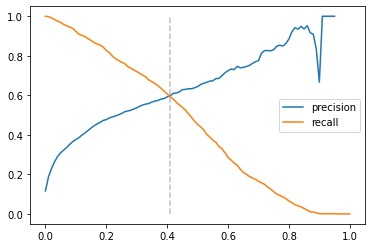

In [69]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.41, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

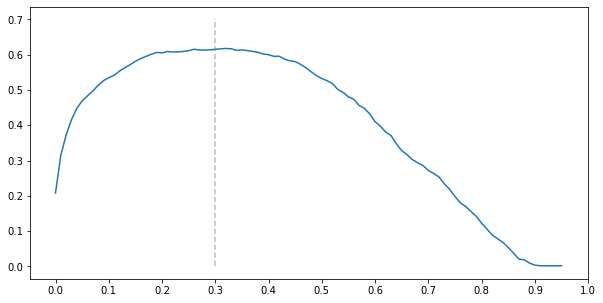

In [70]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

plt.figure(figsize=(10, 5))
plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.3, 0, 0.7, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

The best threshold to get the best f1_score is 0.3

### 3.7 XGBoost model.

There are two ways to tune XGB model:
1. simple line and automatic but it took too much time by using **GridSearchCV**
2. manual and too long in code but it is faster (I done it in different notebook named Tuning_XGB_parameters.ipynb)

In [71]:
xgb_params = [{
    'eta': [0.01,0.03,0.05,0.1,0.3], 
    'max_depth': [1,3,5,8,10,15,20],
    'min_child_weight': [1,5,10,30],
    'subsample': [0.5,1],
    'colsample_bytree': [0.5,1],
    
    'objective': ['binary:logistic'],
    'eval_metric': ['auc'],

    'nthread': [8],
    'seed': [1],
    'verbosity': [1],
}]

In [72]:
gcv_xgb=GridSearchCV(xgb.XGBClassifier(), param_grid=xgb_params, scoring='roc_auc',n_jobs=-1)

In [73]:
#gcv_xgb.fit(X_train, y_train)# this will take too much time to run but the output is written below.
#I run it on kaggle with gpu to make it faster, you can see it from this notebook
#https://www.kaggle.com/abdassalamahmad/bank-full

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,<br>
                                     colsample_bylevel=None,<br>
                                     colsample_bynode=None,<br>
                                     colsample_bytree=None,<br>
                                     enable_categorical=False, gamma=None,<br>
                                     gpu_id=None, importance_type=None,<br>
                                     interaction_constraints=None,<br>
                                     learning_rate=None, max_delta_step=None,<br>
                                     max_depth=None, min_child_weight=None,<br>
                                     missing=nan, monotone_constraints=None,<br>
                                     n_est...<br>
                                     subsample=None, tree_method=None,<br>
                                     validate_parameters=None, verbosity=None),<br>
             n_jobs=-1,<br>
             param_grid=[{'colsample_bytree': [0.5, 1],<br>
                          'eta': [0.01, 0.03, 0.05, 0.1, 0.3],<br>
                          'eval_metric': ['auc'],<br>
                          'max_depth': [1, 3, 5, 8, 10, 15, 20],<br>
                          'min_child_weight': [1, 5, 10, 30], 'nthread': [8],<br>
                          'objective': ['binary:logistic'], 'seed': [1],<br>
                          'subsample': [0.5, 1], 'verbosity': [1]}],<br>
             scoring='roc_auc')<br>

In [74]:
#gcv_xgb.best_params_
# this command will give you these best parameters

{'eta': 0.3,
 'eval_metric': 'auc',
 'max_depth': 3,
 'min_child_weight': 5,
 'nthread': 8,
 'objective': 'binary:logistic',
 'seed': 1,
 'verbosity': 1}

In [75]:
def parse_xgb_output(output):#extract the output of XGB.train and put it in data frame
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [76]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [77]:
scores = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]

### XGB model with the best parameters we got from the (GridSearchCV).

In [78]:
%%capture output
xgb_params = {'eta': 0.3,
 'max_depth': 3,
 'min_child_weight': 5,
 
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 
 'nthread': 8,
 'seed': 1,
 'verbosity': 1}

best_XGB_model = xgb.train(xgb_params, dtrain, num_boost_round=400,
                  verbose_eval=5,#verbose_eval is used to see what is going on with every 5 models trained
                  evals=watchlist)

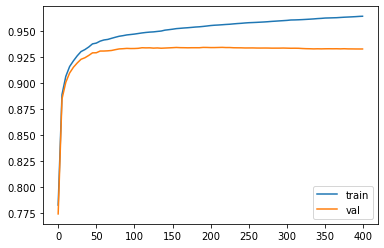

In [79]:
df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [80]:
y_pred1 = best_XGB_model.predict(dval)
y_pred2 = best_XGB_model.predict(dtrain)

auc1=roc_auc_score(y_val, y_pred1)
auc2=roc_auc_score(y_train, y_pred2)
#f1=f1_score(X_val, y_pred1, average='binary')
#print ('f1= %.3f\t auc_val = %.4f\t, auc_train = %.4f' %(f1, auc1, auc2))
print ('auc_val = %.4f\t, auc_train = %.4f' %(auc1, auc2))

auc_val = 0.9326	, auc_train = 0.9639


In [81]:
df_scores = confusion_matrix_dataframe(y_val, y_pred1)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1050,7993,0,0
10,0.1,949,1380,101,6613
20,0.2,858,871,192,7122
30,0.3,750,605,300,7388
40,0.4,640,428,410,7565
50,0.5,515,289,535,7704
60,0.6,396,191,654,7802
70,0.7,278,109,772,7884
80,0.8,183,63,867,7930
90,0.9,82,17,968,7976


This is the presicion and recall

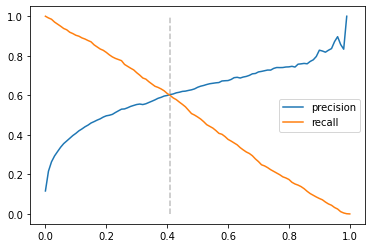

In [82]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.41, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

This is f1_score

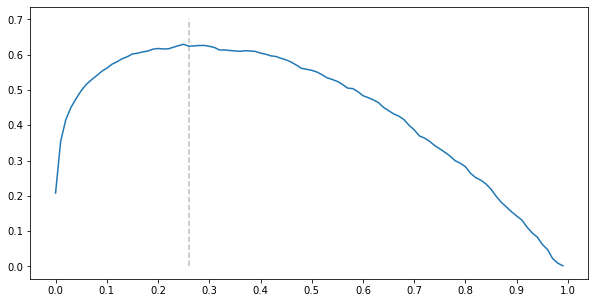

In [83]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

plt.figure(figsize=(10, 5))
plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.26, 0, 0.7, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

I preferred to choose the manual version of XGBoost that I tuned in (Tuning_XGB_parameters.ipynb), Because it is a little better than the GridSearchCV model.<br>

